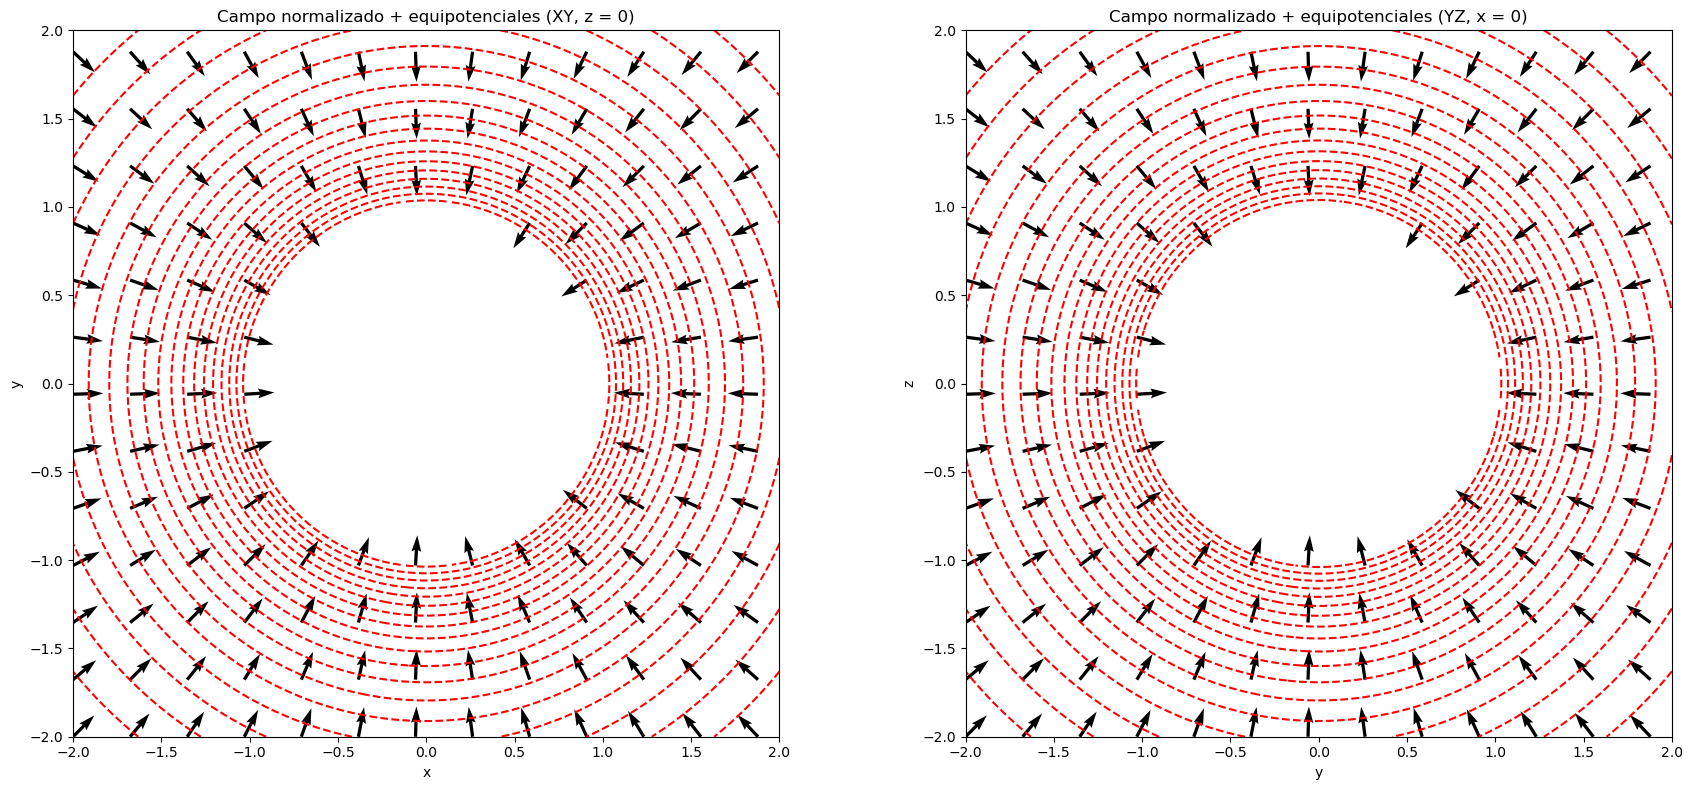

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sympy as sp
from sympy.utilities.lambdify import lambdify
from scipy.integrate import quad

# Definimos variables simbólicas
x, y, z = sp.symbols('x y z', real=True)
r = sp.sqrt(x**2 + y**2 + z**2)

# Constantes
R = 1.0  # Radio de la Tierra normalizado

# Aproximación de g(phi) con sin(phi) ~ z / r
g = 9.780327 * (1 + 0.0053024 * (z / r)**2)

def g_numeric(r_val, z_val):
    return 9.780327 * (1 + 0.0053024 * (z_val / r_val)**2)

def Phi_integrated_numeric(z_val):
    integrand = lambda r_val: g_numeric(r_val, z_val)
    result, _ = quad(integrand, R, 1e3)  # acotamos para evitar divergencia
    return -result

Phi0 = Phi_integrated_numeric(0)
z_scaled = z / R
Phi_poly = Phi0 * (1 + 0.0053024 * z_scaled**2)
Phi_poly = sp.series(Phi_poly, z_scaled, 0, 5).removeO().subs(z_scaled, z / R) * R

Phi_star = Phi_poly
Phi_exterior = (1 / r) * Phi_star.subs({x: x/r**2, y: y/r**2, z: z/r**2})
Phi_exterior_simplified = sp.simplify(Phi_exterior)

g_field = -sp.Matrix([sp.diff(Phi_exterior_simplified, v) for v in (x, y, z)])

Phi_func = lambdify((x, y, z), Phi_exterior_simplified, "numpy")
g_func = lambdify((x, y, z), g_field, "numpy")

res = 100
xv = np.linspace(-2, 2, res)
yv = np.linspace(-2, 2, res)
zv = np.linspace(-2, 2, res)
xm_xy, ym_xy = np.meshgrid(xv, yv)
zm_xy = np.zeros_like(xm_xy)
r_xy = np.sqrt(xm_xy**2 + ym_xy**2)
mask_xy = r_xy >= R

Phi_xy = Phi_func(xm_xy, ym_xy, zm_xy)
Phi_xy[~mask_xy] = np.nan
gxy = g_func(xm_xy, ym_xy, zm_xy)
gx_xy = np.array(gxy[0]).reshape(xm_xy.shape)
gy_xy = np.array(gxy[1]).reshape(ym_xy.shape)
gx_xy[~mask_xy] = np.nan
gy_xy[~mask_xy] = np.nan

# Normalización del campo XY
mag_xy = np.sqrt(gx_xy**2 + gy_xy**2) + 1e-10
gx_xy_norm = gx_xy / mag_xy
gy_xy_norm = gy_xy / mag_xy

ym_yz, zm_yz = np.meshgrid(yv, zv)
xm_yz = np.zeros_like(ym_yz)
r_yz = np.sqrt(ym_yz**2 + zm_yz**2)
mask_yz = r_yz >= R

Phi_yz = Phi_func(xm_yz, ym_yz, zm_yz)
Phi_yz[~mask_yz] = np.nan
gyz = g_func(xm_yz, ym_yz, zm_yz)
gy_yz = np.array(gyz[1]).reshape(ym_yz.shape)
gz_yz = np.array(gyz[2]).reshape(zm_yz.shape)
gy_yz[~mask_yz] = np.nan
gz_yz[~mask_yz] = np.nan

# Normalización del campo YZ
mag_yz = np.sqrt(gy_yz**2 + gz_yz**2) + 1e-10
gy_yz_norm = gy_yz / mag_yz
gz_yz_norm = gz_yz / mag_yz

fig = plt.figure(figsize=(18, 8))

ax1 = fig.add_subplot(1, 2, 1)
c1 = ax1.contour(xv, yv, Phi_xy, levels=np.linspace(np.nanmin(Phi_xy), np.nanmax(Phi_xy), 20), colors='red')
ax1.quiver(xm_xy[::8, ::8], ym_xy[::8, ::8], gx_xy_norm[::8, ::8], gy_xy_norm[::8, ::8], color='black')
ax1.set_aspect('equal')
ax1.set_title("Campo normalizado + equipotenciales (XY, z = 0)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

ax2 = fig.add_subplot(1, 2, 2)
c2 = ax2.contour(yv, zv, Phi_yz, levels=np.linspace(np.nanmin(Phi_yz), np.nanmax(Phi_yz), 20), colors='red')
ax2.quiver(ym_yz[::8, ::8], zm_yz[::8, ::8], gy_yz_norm[::8, ::8], gz_yz_norm[::8, ::8], color='black')
ax2.set_aspect('equal')
ax2.set_title("Campo normalizado + equipotenciales (YZ, x = 0)")
ax2.set_xlabel("y")
ax2.set_ylabel("z")

plt.tight_layout()
plt.show()


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3D, Line3DCollection
from scipy.integrate import solve_ivp
import cupy as cp

# Constantes
R = 1.0  # Radio del planeta (esfera sólida)

# Campo gravitacional 3D aproximado
def g_vectorized(x, y, z):
    r = cp.sqrt(x**2 + y**2 + z**2)
    g = cp.where(r >= R, 9.780327 * (1 + 0.0053024 * (z / r)**2), 0.0)
    return -g * x / r, -g * y / r, -g * z / r

# Sistema dinámico en 3D
def satelite_ode(t, state):
    x, y, z, vx, vy, vz = state
    gx, gy, gz = g_vectorized(cp.array(x), cp.array(y), cp.array(z))
    return [vx, vy, vz, gx.item(), gy.item(), gz.item()]

# Energía total
def energia_total(x, y, z, vx, vy, vz):
    r = np.sqrt(x**2 + y**2 + z**2)
    g = 9.780327 * (1 + 0.0053024 * (z / r)**2) if r >= R else 0.0
    phi = -g * r
    energia = 0.5 * (vx**2 + vy**2 + vz**2) + phi
    return energia

# Simulación de órbitas ligadas
v_candidates = np.linspace(0.2, 1.5, 200)
found = 0
for i, v0 in enumerate(v_candidates):
    state0 = [1.5, 0.0, 0.0, 0.0, v0, 0.1]  # Posición fuera de la esfera (r0 > R)
    E = energia_total(*state0)
    if E < 0:
        print(f"v0 = {v0:.3f}, energía = {E:.3f} -> ligado")

        sol = solve_ivp(satelite_ode, (0, 150), state0, t_eval=np.linspace(0, 150, 1200), rtol=1e-6)
        x_vals, y_vals, z_vals = sol.y[0], sol.y[1], sol.y[2]

        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111, projection='3d')
        lim = 2.5
        ax.set_xlim([-lim, lim])
        ax.set_ylim([-lim, lim])
        ax.set_zlim([-lim, lim])
        ax.set_box_aspect([1, 1, 1])
        ax.set_title(f'Orbita 3D ligada: v0={v0:.2f}')

        # Esfera sólida del planeta
        u, v = np.mgrid[0:2*np.pi:60j, 0:np.pi:30j]
        xs = R * np.cos(u) * np.sin(v)
        ys = R * np.sin(u) * np.sin(v)
        zs = R * np.cos(v)
        ax.plot_surface(xs, ys, zs, color='blue', alpha=0.6, edgecolor='k')

        # Trayectoria y punto
        traj_line = Line3D([], [], [], color='k', linewidth=1.5)
        ax.add_line(traj_line)
        point, = ax.plot([], [], [], 'ro')

        def init():
            traj_line.set_data_3d([], [], [])
            point.set_data_3d([], [], [])
            return traj_line, point

        def update(frame):
            traj_line.set_data_3d(x_vals[:frame], y_vals[:frame], z_vals[:frame])
            point.set_data_3d([x_vals[frame]], [y_vals[frame]], [z_vals[frame]])
            return traj_line, point

        ani = FuncAnimation(fig, update, frames=len(x_vals), init_func=init, blit=False, interval=1000/60)
        ani.save(f"orbita_3d_ligada_{i:03d}.gif", writer=PillowWriter(fps=60))
        plt.close()

        found += 1
        if found >= 1:
            break

v0 = 0.200, energía = -14.645 -> ligado
